In [18]:
# Required imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import sklearn.tree as tree
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF
import multiprocessing

In [2]:
# Read dataset
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv('../data/test.csv')
combine = [train_df, test_df]
num_cores = multiprocessing.cpu_count() - 1

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Get some info about train and test dataframe
train_df.info()
print("="*60)
test_df.info()
print("="*60)
print("Shape of train set is {}", train_df.shape)
print("Shape of test set is {}", test_df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

In [4]:
# Useless features
useless_features = ['PassengerId', 'Ticket', 'Cabin']
for df in combine:
    df.drop(useless_features, axis = 1, inplace = True, errors='ignore')
    
train_df.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S
5,0,3,"Moran, Mr. James",male,NaN,0,0,8.4583,Q
6,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,51.8625,S
7,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,21.0750,S
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,11.1333,S
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,30.0708,C


In [5]:
# Separate designation from names
for df in combine:
    df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand = False)

# Create a rare designation
for df in combine:
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')

# Remove name feature
for df in combine:
    df.drop('Name', axis = 1, inplace = True)
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [6]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,Mr
1,1,1,female,38.0,1,0,71.2833,C,Mrs
2,1,3,female,26.0,0,0,7.9250,S,Miss
3,1,1,female,35.0,1,0,53.1000,S,Mrs
4,0,3,male,35.0,0,0,8.0500,S,Mr


In [7]:
# Label encode categorical features
categorical_features = ['Sex', 'Title', "Embarked"]
encoder_storage = {}
for feature in categorical_features:
    encoder = LabelEncoder()
    train_df[feature] = encoder.fit_transform(train_df[feature])
    test_df[feature] = encoder.transform(test_df[feature])
    encoder_storage[feature] = encoder

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,1,22.0,1,0,7.2500,2,2
1,1,1,0,38.0,1,0,71.2833,0,3
2,1,3,0,26.0,0,0,7.9250,2,1
3,1,1,0,35.0,1,0,53.1000,2,3
4,0,3,1,35.0,0,0,8.0500,2,2


In [8]:
# Find family size
for df in combine:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = 0
    df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1
    df.drop(['Parch', 'SibSp', 'FamilySize'], axis = 1, inplace = True)

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,1,22.0,7.2500,2,2,0
1,1,1,0,38.0,71.2833,0,3,0
2,1,3,0,26.0,7.9250,2,1,1
3,1,1,0,35.0,53.1000,2,3,0
4,0,3,1,35.0,8.0500,2,2,1


In [9]:
# Find info after a bit of preprocessing
for df in combine:
    print(df.info())
    print("="*60)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       714 non-null    float64
 4   Fare      891 non-null    float64
 5   Embarked  891 non-null    int64  
 6   Title     891 non-null    int64  
 7   IsAlone   891 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 55.8 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    int64  
 2   Age       332 non-null    float64
 3   Fare      417 non-null    float64
 4   Embarked  418 non-null    int64  
 5   Title     418 non-null    int64  
 6   IsAlone   418 non-null    int

In [10]:
# Age is the only feature that contains null values in both the df
guess_ages = np.zeros((2, 3))
for df in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = df[(df['Sex'] == i) & (df['Pclass'] == j+1)]['Age'].dropna()
            
            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            df.loc[ (df.Age.isnull()) & (df.Sex == i) & (df.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    df['Age'] = df['Age'].astype(int)

train_df.info()
print("="*60)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    int64  
 4   Fare      891 non-null    float64
 5   Embarked  891 non-null    int64  
 6   Title     891 non-null    int64  
 7   IsAlone   891 non-null    int64  
dtypes: float64(1), int64(7)
memory usage: 55.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    int64  
 2   Age       418 non-null    int64  
 3   Fare      417 non-null    float64
 4   Embarked  418 non-null    int64  
 5   Title     418 non-null    int64  
 6   IsAlone   418 non-null    int64  


In [11]:
# Still there is fare value in test df that contains null values
test_df['Fare'].fillna(test_df['Fare'].mean(), inplace = True)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    int64  
 2   Age       418 non-null    int64  
 3   Fare      418 non-null    float64
 4   Embarked  418 non-null    int64  
 5   Title     418 non-null    int64  
 6   IsAlone   418 non-null    int64  
dtypes: float64(1), int64(6)
memory usage: 23.0 KB


In [12]:
# Finally, normalize the continuous feature of age and fare
continuous_features = ['Age', 'Fare']
scaler = StandardScaler()
train_df[continuous_features] = scaler.fit_transform(train_df[continuous_features])
test_df[continuous_features] = scaler.transform(test_df[continuous_features])

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,1,-0.531048,-0.502445,2,2,0
1,1,1,0,0.670256,0.786845,0,3,0
2,1,3,0,-0.230722,-0.488854,2,1,1
3,1,1,0,0.445012,0.420730,2,3,0
4,0,3,1,0.445012,-0.486337,2,2,1


In [13]:
# Split training set
X_train = train_df.drop("Survived", axis = 1)
y_train = train_df['Survived']
X_test = test_df.copy()

In [14]:
# Base decision tree
dt = tree.DecisionTreeClassifier()
dt = dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
acc_dt = round(dt.score(X_train, y_train) * 100, 2)
acc_dt

98.2

* Even though the accuracy is high, there is a huge generalization gap (known due to previous homework assignment) indicating that the model has overfit.

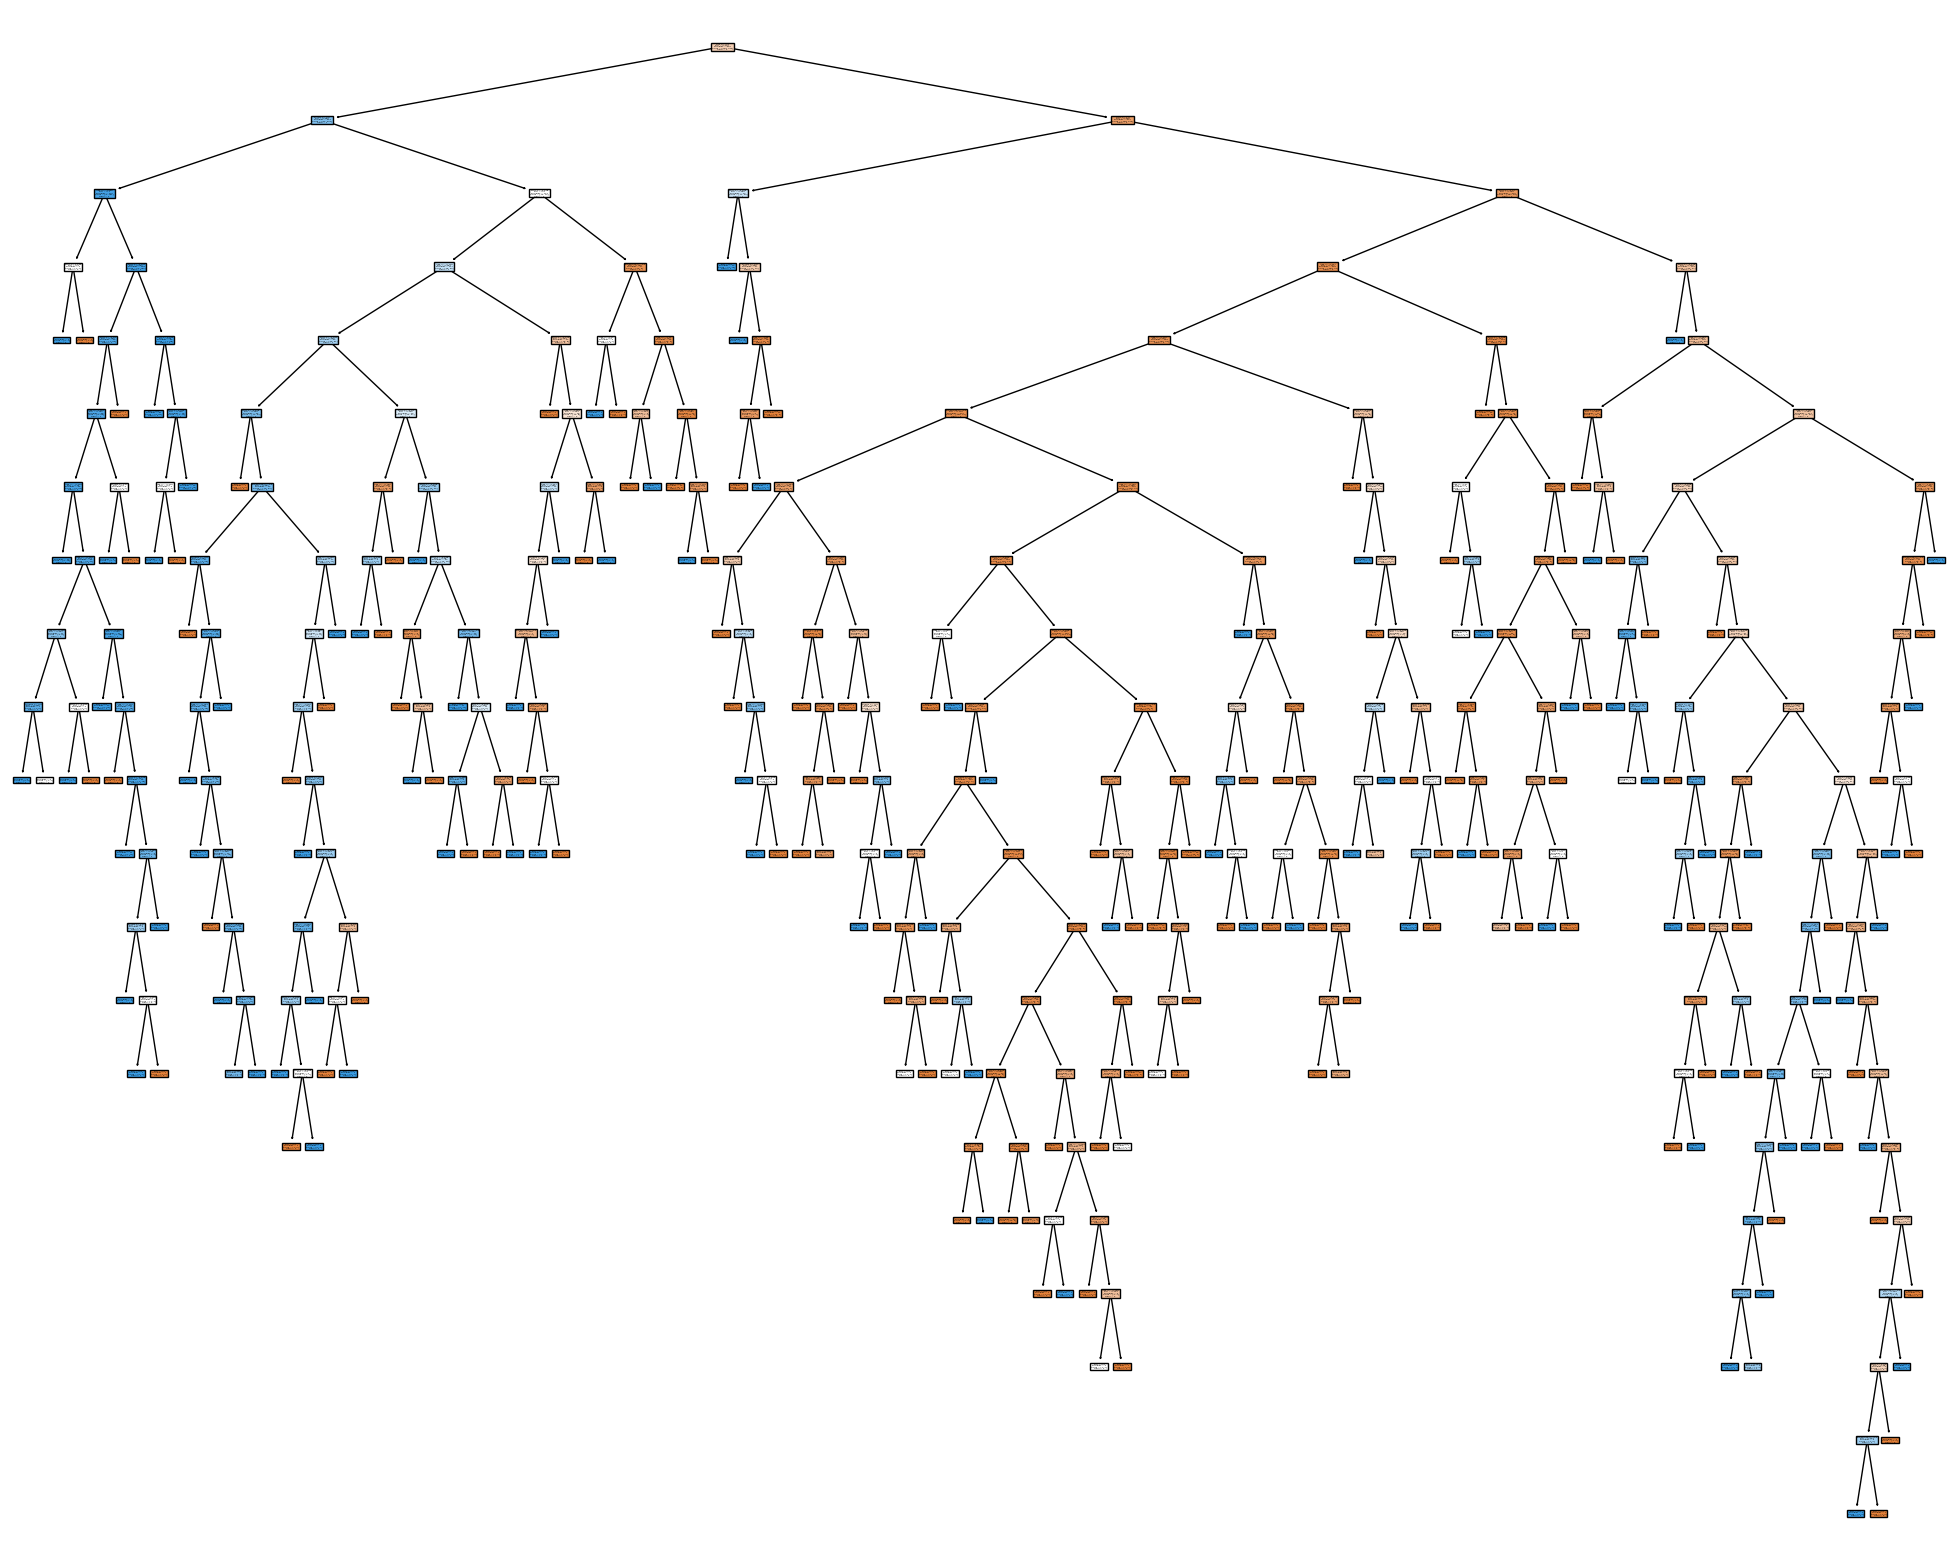

In [15]:
# Visualize decision tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt, feature_names = X_train.columns, class_names=['0', '1'], filled = True)

In [16]:
class TreeClassifiers:
    def __init__(self, classifier):
        self.model = classifier
        self.k = 5 # For 5 fold cross validation

    def fit(self, X_train, y_train):
        param_grid = {
            "max_depth": list(np.arange(1, 100, step=24)),
            "min_samples_split": list(np.arange(10, 500, step=10)),
            "max_leaf_nodes": [2, 3, 4, 5]
            }
        
        grid_search = GridSearchCV(
            self.model,
            param_grid,
            cv = self.k,
            verbose = 2,
            scoring='accuracy',
            n_jobs = num_cores
        )
        
        grid_search.fit(X_train, y_train)
        
        return grid_search.best_params_

In [17]:
dt = TreeClassifiers(DT(criterion='gini'))
dt_best_params = dt.fit(X_train, y_train)
dt_best_params

Fitting 5 folds for each of 980 candidates, totalling 4900 fits
[CV] END max_depth=1, max_leaf_nodes=2, min_samples_split=10; total time=   0.0s
[CV] END max_depth=1, max_leaf_nodes=2, min_samples_split=10; total time=   0.0s
[CV] END max_depth=1, max_leaf_nodes=2, min_samples_split=20; total time=   0.0s
[CV] END max_depth=1, max_leaf_nodes=2, min_samples_split=10; total time=   0.0s
[CV] END max_depth=1, max_leaf_nodes=2, min_samples_split=20; total time=   0.0s[CV] END max_depth=1, max_leaf_nodes=2, min_samples_split=20; total time=   0.0s

[CV] END max_depth=1, max_leaf_nodes=2, min_samples_split=20; total time=   0.0s
[CV] END max_depth=1, max_leaf_nodes=2, min_samples_split=20; total time=   0.0s
[CV] END max_depth=1, max_leaf_nodes=2, min_samples_split=30; total time=   0.0s
[CV] END max_depth=1, max_leaf_nodes=2, min_samples_split=30; total time=   0.0s
[CV] END max_depth=1, max_leaf_nodes=2, min_samples_split=10; total time=   0.0s
[CV] END max_depth=1, max_leaf_nodes=2, min_s

{'max_depth': 25, 'max_leaf_nodes': 4, 'min_samples_split': 250}

In [22]:
dt_cv = cross_validate(
    estimator = DT(
        criterion = 'gini',
        max_depth = dt_best_params['max_depth'],
        max_leaf_nodes = dt_best_params['max_leaf_nodes'],
        min_samples_leaf = dt_best_params['min_samples_split']
    ),
    X = X_train,
    y = y_train,
    verbose = 1,
    return_train_score = True,
    cv = 5,
    scoring = 'accuracy'
)

dt_cv['test_score'].mean()

0.7094218818655451

In [23]:
rf = TreeClassifiers(RF(criterion='gini'))
rf_best_params = rf.fit(X_train, y_train)
rf_best_params

Fitting 5 folds for each of 980 candidates, totalling 4900 fits
[CV] END max_depth=1, max_leaf_nodes=2, min_samples_split=10; total time=   0.2s
[CV] END max_depth=1, max_leaf_nodes=2, min_samples_split=10; total time=   0.2s
[CV] END max_depth=1, max_leaf_nodes=2, min_samples_split=20; total time=   0.2s
[CV] END max_depth=1, max_leaf_nodes=2, min_samples_split=10; total time=   0.3s
[CV] END max_depth=1, max_leaf_nodes=2, min_samples_split=10; total time=   0.2s
[CV] END max_depth=1, max_leaf_nodes=2, min_samples_split=10; total time=   0.3s
[CV] END max_depth=1, max_leaf_nodes=2, min_samples_split=20; total time=   0.2s
[CV] END max_depth=1, max_leaf_nodes=2, min_samples_split=20; total time=   0.3s
[CV] END max_depth=1, max_leaf_nodes=2, min_samples_split=20; total time=   0.3s
[CV] END max_depth=1, max_leaf_nodes=2, min_samples_split=20; total time=   0.2s
[CV] END max_depth=1, max_leaf_nodes=2, min_samples_split=30; total time=   0.3s
[CV] END max_depth=1, max_leaf_nodes=2, min_s

{'max_depth': 73, 'max_leaf_nodes': 5, 'min_samples_split': 10}

In [24]:
rf_cv = cross_validate(
    estimator = RF(
        criterion = 'gini',
        max_depth = rf_best_params['max_depth'],
        max_leaf_nodes = rf_best_params['max_leaf_nodes'],
        min_samples_leaf = rf_best_params['min_samples_split']
    ),
    X = X_train,
    y = y_train,
    verbose = 1,
    return_train_score = True,
    cv = 5,
    scoring = 'accuracy'
)

rf_cv['test_score'].mean()

0.8013495700207143